editing the weights is needed

# Importing Libs

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

**Specify the `exportdate` below**

In [ ]:
exportdate = pd.Timestamp('2023-05-17T12')

# Computing Feature 1: Warningsign

## Importing dataset

Place all your "file.csv" files in a folder named files and then use its path as mentioned below

In [ ]:
# use list comprehension to read all files
path = r"files"
all_files = [pd.read_csv(filename, dtype={'BizDomainId': 'string', 'DealId': 'string'}, low_memory=False) for filename in glob.glob(os.path.join(path , "*.csv"))]

# combine dataframes into a single dataframe
df = pd.concat(all_files, axis=0, ignore_index=True)

# rename columns
df = df.rename(columns={'IsDeleted':'IsDeletedDeal','Id':'DealId' , 'Id.1':'ActivityId','IsDeleted.1':'IsDeletedActivity','RegisterTime':'RegisterTimeDeal',
                        'Status':'StatusDeal','RegisterDate':'RegisterDateActivity','IsDone':'IsDoneActivity','DoneDate':'DoneDateActivity'})

# manipulate columns
df.loc[: , ['BizDomainId' , 'OwnerId' , 'DealId']] = df.loc[: , ['BizDomainId' , 'OwnerId' , 'DealId']].apply(lambda x: x.str.lower() , axis=1)
df['DoneDateActivity'] = np.where(df['IsDoneActivity']==False , np.nan ,df['DoneDateActivity'])
df['DealFinishTime'] = np.where(df['StatusDeal']==1 , df['ChangeToWonTime'] , np.where(df['StatusDeal']==2 , df['ChangeToLossTime'] , None))
# print(df.shape)
df['temp_max'] = np.nanmax(df[['RegisterDateActivity' , 'DoneDateActivity' , 'DealFinishTime' , 'RegisterTimeDeal']].fillna('00'), axis=1)
df['temp_min'] = np.nanmin(df[['RegisterDateActivity' , 'DoneDateActivity' , 'DealFinishTime' , 'RegisterTimeDeal']].fillna('2030-01-01'), axis=1)
df['temp_max'] = pd.to_datetime(df['temp_max'], errors='coerce')
df['temp_min'] = pd.to_datetime(df['temp_min'], errors='coerce')
df = df.dropna(subset=['temp_min', 'temp_max'], how='any')
df.drop(['temp_min' , 'temp_max'] , axis = 1 ,inplace=True)
# print(df.shape)

# convert date/time columns to datetime dtype
df['RegisterDateActivity'] = pd.to_datetime(df['RegisterDateActivity'])
df['DoneDateActivity'] = pd.to_datetime(df['DoneDateActivity'])
df['RegisterTimeDeal'] = pd.to_datetime(df['RegisterTimeDeal'])
df['DealFinishTime'] = pd.to_datetime(df['DealFinishTime'])
# print(df.shape)

# drop columns
df.drop(['ChangeToWonTime' , 'ChangeToLossTime' , 'ActivityId'], axis=1, inplace=True)

print(f'Number of rows: {df.shape[0]}')
df.head()

Number of rows: 1166362


,BizDomainId,OwnerId,DealId,IsDeletedDeal,RegisterTimeDeal,StatusDeal,IsDeletedActivity,RegisterDateActivity,IsDoneActivity,DoneDateActivity,DealFinishTime
0,3543cb3b-e043-404f-9ff8-039b09ee39ba,ba95e6c3-489f-4fe4-baaf-0499531abd27,42792665-680b-4b0e-b00a-49204971e2ed,0,2023-05-01 09:56:23,1,0.0,2023-05-01 09:59:36,0.0,NaT,2023-05-01 12:35:28
1,a1658ee2-1ed3-48d2-8dc4-de0b1a540b5c,e09e359f-0026-40c0-9782-dec77f2a2d97,92ea80e4-a19a-437e-9e3c-04cfb84f8291,0,2023-04-26 06:09:56,1,0.0,2023-04-24 11:55:47,1.0,2023-04-24 11:55:47,2023-04-26 06:09:56
2,e21bf063-d611-4121-8ea2-9bfff327d8c0,b751ba47-aaf1-4e3d-9a4e-5d6a02296671,8a2d6c6e-9f65-4273-910a-986fa266de2b,1,2023-04-06 10:43:00,0,0.0,2023-04-06 10:43:01,1.0,2023-04-06 10:43:00,NaT
3,a75b956b-0b13-4b8e-990f-2f61757df9ac,4e434f1e-de88-458f-8379-74dfeb20ce6b,6ac4f29b-9855-40a4-ba1b-6de1b59720dc,0,2023-04-05 12:29:41,0,0.0,2023-05-14 06:44:09,1.0,2023-05-15 07:18:10,NaT
4,70dbaff3-70e9-47ca-9415-53c293a085f1,4410921a-db18-4d73-b222-bd395f0a2e7d,f6410ff5-b412-4178-859d-fde72bf4e479,0,2022-04-17 12:41:15,1,0.0,2022-04-17 12:41:15,1.0,2022-04-17 12:41:15,2022-04-19 04:53:08


## Joining ExpireDate Dataset

In [ ]:
# Load and merge the expiration date data
ExpireDate = pd.read_csv(r"Training Data\ExpireDate.csv", dtype={"Id": str})
ExpireDate = ExpireDate.rename(columns={'Id':'BizDomainId','RegisterTime':'BizRegisterDate','ExpirationDate':'BizExpireDate' , 'LastAccessTime':'BizAccessDate' , 'UserId':'OwnerId'})
ExpireDate[['BizDomainId' , 'OwnerId']] = ExpireDate[['BizDomainId' , 'OwnerId']].apply(lambda x: x.str.lower(),axis=1)
df = pd.merge(df, ExpireDate, how='left')

# Convert datetime columns
date_columns = ['BizRegisterDate', 'BizExpireDate', 'BizAccessDate']
df[date_columns] = df[date_columns].apply(pd.to_datetime)

# Determine whether the business is expired
df['BizIsExpired?'] = np.where(df['BizExpireDate'] >= exportdate, 0, 1)

# Keep the bizdomains that last longer than 2 months
from dateutil.relativedelta import relativedelta
df = df[df['BizRegisterDate'] <= (exportdate - relativedelta(months=2))]

# Delete data where IsDeletedDeal=1 and StatusDeal=0
mask = df.query('IsDeletedDeal == 1 and StatusDeal == 0').index
shape1 = len(df)
df = df.loc[~df.index.isin(mask)]
shape2 = len(df)
print(f"Number of deleted cases: {shape1-shape2}, number of rows before: {shape1}, number of rows after: {shape2}")

Number of deleted cases: 55617, number of rows before: 1084044, number of rows after: 1028427


In [ ]:
def apply_function(df):
    mask = (df['StatusDeal'] == 0) & (df['IsDeletedDeal'] == 0)
    expired_mask = mask & (df['BizIsExpired?'] == 1)
    df.loc[expired_mask, 'DealFinishTime'] = np.minimum(df.loc[expired_mask, 'BizExpireDate'], df.loc[expired_mask, 'BizAccessDate'])
    df.loc[expired_mask & (df['IsDoneActivity'] == 0) & (df['IsDeletedActivity'] == 0), 'DoneDateActivity'] = df.loc[expired_mask, 'DealFinishTime']
    df.loc[mask & ~(df['BizIsExpired?'] == 1), 'DealFinishTime'] = exportdate
    df.loc[mask & ~(df['BizIsExpired?'] == 1) & (df['IsDoneActivity'] == 0) & (df['IsDeletedActivity'] == 0), 'DoneDateActivity'] = exportdate
    df.drop(columns=['BizAccessDate' , 'BizExpireDate' , 'BizRegisterDate'], inplace=True)
    return df

df = apply_function(df)
df.head()

,BizDomainId,OwnerId,DealId,IsDeletedDeal,RegisterTimeDeal,StatusDeal,IsDeletedActivity,RegisterDateActivity,IsDoneActivity,DoneDateActivity,DealFinishTime,BizIsExpired?
0,3543cb3b-e043-404f-9ff8-039b09ee39ba,ba95e6c3-489f-4fe4-baaf-0499531abd27,42792665-680b-4b0e-b00a-49204971e2ed,0,2023-05-01 09:56:23,1,0.0,2023-05-01 09:59:36,0.0,NaT,2023-05-01 12:35:28,0
1,a1658ee2-1ed3-48d2-8dc4-de0b1a540b5c,e09e359f-0026-40c0-9782-dec77f2a2d97,92ea80e4-a19a-437e-9e3c-04cfb84f8291,0,2023-04-26 06:09:56,1,0.0,2023-04-24 11:55:47,1.0,2023-04-24 11:55:47,2023-04-26 06:09:56,0
3,a75b956b-0b13-4b8e-990f-2f61757df9ac,4e434f1e-de88-458f-8379-74dfeb20ce6b,6ac4f29b-9855-40a4-ba1b-6de1b59720dc,0,2023-04-05 12:29:41,0,0.0,2023-05-14 06:44:09,1.0,2023-05-15 07:18:10,2023-05-17 12:00:00,0
4,70dbaff3-70e9-47ca-9415-53c293a085f1,4410921a-db18-4d73-b222-bd395f0a2e7d,f6410ff5-b412-4178-859d-fde72bf4e479,0,2022-04-17 12:41:15,1,0.0,2022-04-17 12:41:15,1.0,2022-04-17 12:41:15,2022-04-19 04:53:08,1
5,a1658ee2-1ed3-48d2-8dc4-de0b1a540b5c,e09e359f-0026-40c0-9782-dec77f2a2d97,aa9c2561-3108-4c00-a6a2-b4c9bca6e2d5,0,2023-04-25 07:04:48,2,0.0,2023-04-26 06:20:24,1.0,2023-04-26 09:10:23,2023-05-07 10:33:57,0


Function for Fixing the order of the times of occurrence

DealStartTime<ActivityStartTime<ActivityFinishTime<DealFinishTime

In [ ]:
df['RegisterTimeDeal']=np.minimum(df['RegisterTimeDeal'] , df['DealFinishTime'])
mask = ~pd.isna(df['RegisterDateActivity'])
df.loc[mask, 'RegisterDateActivity'] = np.maximum(df.loc[mask, 'RegisterTimeDeal'] ,
                                     np.minimum(df.loc[mask,'RegisterDateActivity'] , df.loc[mask,'DealFinishTime']))
df.loc[mask , 'DoneDateActivity'] = np.minimum(df.loc[mask,'DealFinishTime'] ,
                                     np.maximum(df.loc[mask,'RegisterTimeDeal'] , df.loc[mask,'DoneDateActivity']))
df.loc[mask,'DoneDateActivity'] = np.maximum(df.loc[mask,'RegisterDateActivity'] , df.loc[mask , 'DoneDateActivity'])
df.shape

(1028427, 12)

Activity: IsDone=0, IsDeleted=1

In [ ]:
mask = (df['IsDoneActivity']==0) & (df['IsDeletedActivity']==1)
df = df.loc[~mask ,:]

Completing finish time of activities

In [ ]:
# Calculate average of other activities of deal
df['diff'] = (df['DoneDateActivity'] - df['RegisterDateActivity']).dt.total_seconds()
df['avg_diff_deal'] = df['diff'].groupby(df['DealId']).transform(lambda x: np.nanmean(x))
mask_deal = pd.isna(df['DoneDateActivity']) & (df.groupby('DealId')['DealId'].transform('size') > 1)
df.loc[mask_deal, 'DoneDateActivity'] = df.loc[mask_deal, 'RegisterDateActivity'] + pd.to_timedelta(df.loc[mask_deal, 'avg_diff_deal'], unit='s')
df.drop(columns=['diff', 'avg_diff_deal'], inplace=True)

# Calculate average of other activities of biz
df['diff'] = (df['DoneDateActivity'] - df['RegisterDateActivity']).dt.total_seconds()
df['avg_diff_biz'] = df['diff'].groupby(df['BizDomainId']).transform(lambda x: np.nanmean(x))
mask_biz = pd.isna(df['DoneDateActivity'])
df.loc[mask_biz, 'DoneDateActivity'] = df.loc[mask_biz, 'RegisterDateActivity'] + pd.to_timedelta(df.loc[mask_biz, 'avg_diff_biz'], unit='s')
df.drop(columns=['diff', 'avg_diff_biz'], inplace=True)

# Clip DoneDateActivity to DealFinishTime
df['DoneDateActivity'] = np.minimum(df['DoneDateActivity'], df['DealFinishTime'])
df.shape

(1011714, 12)

## Export Cleaned Dataset

Export data based on the shape of the df, each 1,000,000 rows should be saved a separate csv file

In [ ]:
os.makedirs('files_cleaned', exist_ok=True)
for i, chunk in enumerate(df.groupby(np.arange(len(df)) // 1000000)):
    chunk[1].to_csv(f'files_cleaned/df_file_cleaned{i+1}.csv', index=False)

**Importing the cleaned dataset**

Change the directory of exported data to `files_cleaned` and then use the cell below if you desire to use them. Exporting should be done because the cleaned dataset will be used in future Feature Extractions.

In [ ]:
# path = r"files_cleaned" # use your path
# all_files = glob.glob(os.path.join(path , "*.csv"))

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, header=0)
#     li.append(df)

# df = pd.concat(li, axis=0, ignore_index=True)
# df.loc[:, ['RegisterTimeDeal' , 'DealFinishTime','RegisterDateActivity','DoneDateActivity']] = df.loc[:,['RegisterTimeDeal' , 'DealFinishTime','RegisterDateActivity','DoneDateActivity']].apply(pd.to_datetime)
# df.head()

Function for calculating the metric of proportion of warning time to total deal time

In [ ]:
def merge_times(intervals):
    intervals.sort(key=lambda x: x[0])

    res = [intervals[0]]
    for idx in range(1, len(intervals)):
        curr = intervals[idx]
        prev = res[-1]

        # Check for overlap
        if prev[1] < curr[0]:  # No overlap
            res.append(curr)
        else:
            # Overlap, update end time
            prev[1] = max(prev[1], curr[1])

    return res

def no_warning_ratio(start_time, end_time, intervals):
    '''
    input:
    start_time = RegisterTime of a deal
    end_time = DealFinishTime
    intervals = related intervals for activities on a specific deal

    ----------------------

    output:
    a dictionary with the following keys:
    - 'no_warning_ratio': ratio of (not showing warning signal)/(duration of the deal)
    - 'deal_duration': duration of the deal in seconds
    '''
    end_time_int = pd.Timedelta(end_time - start_time).total_seconds()

    if pd.isna(intervals.iloc[0, 0]):
        return {'no_warning_ratio': 0, 'deal_duration': end_time_int}
    elif end_time_int == 0:
        return {'no_warning_ratio': 0, 'deal_duration': 0}
    else:
        intervals = intervals.sub(start_time).apply(lambda x: x.dt.total_seconds()).values.tolist()
        merged = merge_times(intervals)
        with_activity = np.sum(end - start for start, end in merged)
        ratio = with_activity / end_time_int
        return {'no_warning_ratio': ratio, 'deal_duration': end_time_int}


def metric_activation_function(df):
    '''
    input:
    dataframe of the groupby function applied to DealIds

    ----------------------

    output:
    a dictionary with the following keys:
    - 'BizDomainId': the ID of the business domain
    - 'OwnerId': the ID of the Owner of the Deal
    - 'DealId': the ID of the deal
    - 'metric': the no_warning_ratio for the deal
    - 'DealDuration': the duration of the deal in seconds
    '''
    BizId = df.loc[:, 'BizDomainId'].values[0]
    OwnerId = df.loc[: , 'OwnerId'].values[0]
    DealId = df.loc[:, 'DealId'].values[0]
    start_time = df.loc[:, 'RegisterTimeDeal'].values[0]
    end_time = df.loc[:, 'DealFinishTime'].values[0]
    intervals = df.loc[:, ['RegisterDateActivity', 'DoneDateActivity']]
    res = no_warning_ratio(start_time, end_time, intervals)
    return {'BizDomainId': BizId,'OwnerId':OwnerId ,'DealId': DealId, 'metric': res['no_warning_ratio'], 'DealDuration': res['deal_duration']}


metric = df.groupby('DealId').apply(metric_activation_function)
metric = pd.DataFrame(metric.tolist())

Aggregating for OwnerId by the means of Calculating expectation (weighted average)

In [ ]:
def AggreagtorOwnerId(df):
    BizId = df.loc[: , 'BizDomainId'].values[0]
    OwnerId=df.loc[:,'OwnerId'].values[0]
    if np.sum(df['DealDuration'])==0:
        return {'BizDomainId': BizId,'OwnerId':OwnerId , 'no_warning_sign':0}
    else:
        return {'BizDomainId': BizId,'OwnerId': OwnerId , 'no_warning_sign':
               np.sum(df['metric']*df['DealDuration'])/df['DealDuration'].sum()}

final_df = metric.groupby('OwnerId').apply(AggreagtorOwnerId)
final_df = pd.DataFrame(final_df.tolist())

## Output Feature 1

In [ ]:
final_df = pd.merge(final_df , df[['BizDomainId','OwnerId','BizIsExpired?']] , how='left',
                    on = ['BizDomainId' , 'OwnerId'])
final_df = final_df.drop_duplicates().rename(columns={'no_warning_sign':'WarningSign'})
final_df['WarningSign'] = 1-final_df['WarningSign']
final_df = final_df.loc[: , ['BizDomainId' , 'OwnerId' , 'BizIsExpired?' , 'WarningSign']]
os.makedirs('Notebooks Data Process', exist_ok=True)
final_df.to_csv('Notebooks Data Process/1. WarningSign.csv',index=0)

# Computing Other Features

importing cleaned files

In [ ]:
path = r"files_cleaned" # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))

li = [pd.read_csv(filename,dtype={'BizDomainId': 'string', 'DealId': 'string' , 'OwnerId':'string'},parse_dates=[
    'RegisterTimeDeal' , 'DealFinishTime','RegisterDateActivity','DoneDateActivity']) for filename in all_files]

file_cleaned = pd.concat(li, axis=0, ignore_index=True)
file_cleaned.head()

,BizDomainId,OwnerId,DealId,IsDeletedDeal,RegisterTimeDeal,StatusDeal,IsDeletedActivity,RegisterDateActivity,IsDoneActivity,DoneDateActivity,DealFinishTime,BizIsExpired?
0,3543cb3b-e043-404f-9ff8-039b09ee39ba,ba95e6c3-489f-4fe4-baaf-0499531abd27,42792665-680b-4b0e-b00a-49204971e2ed,0,2023-05-01 09:56:23,1,0.0,2023-05-01 09:59:36,0.0,2023-05-01 10:29:44.333333333,2023-05-01 12:35:28,0
1,a1658ee2-1ed3-48d2-8dc4-de0b1a540b5c,e09e359f-0026-40c0-9782-dec77f2a2d97,92ea80e4-a19a-437e-9e3c-04cfb84f8291,0,2023-04-26 06:09:56,1,0.0,2023-04-26 06:09:56,1.0,2023-04-26 06:09:56.000000000,2023-04-26 06:09:56,0
2,a75b956b-0b13-4b8e-990f-2f61757df9ac,4e434f1e-de88-458f-8379-74dfeb20ce6b,6ac4f29b-9855-40a4-ba1b-6de1b59720dc,0,2023-04-05 12:29:41,0,0.0,2023-05-14 06:44:09,1.0,2023-05-15 07:18:10.000000000,2023-05-17 12:00:00,0
3,70dbaff3-70e9-47ca-9415-53c293a085f1,4410921a-db18-4d73-b222-bd395f0a2e7d,f6410ff5-b412-4178-859d-fde72bf4e479,0,2022-04-17 12:41:15,1,0.0,2022-04-17 12:41:15,1.0,2022-04-17 12:41:15.000000000,2022-04-19 04:53:08,1
4,a1658ee2-1ed3-48d2-8dc4-de0b1a540b5c,e09e359f-0026-40c0-9782-dec77f2a2d97,aa9c2561-3108-4c00-a6a2-b4c9bca6e2d5,0,2023-04-25 07:04:48,2,0.0,2023-04-26 06:20:24,1.0,2023-04-26 09:10:23.000000000,2023-05-07 10:33:57,0


Importing Feature 1 Final Dataset and ExpireDataset

In [ ]:
from dateutil.relativedelta import relativedelta
df = pd.read_csv(r"Notebooks Data Process/1. WarningSign.csv")
expire = pd.read_csv(r"Training Data/ExpireDate.csv").rename(columns={'Id':'BizDomainId' , 'UserId':'OwnerId'})
expire[['BizDomainId' , 'OwnerId']] = expire[['BizDomainId' , 'OwnerId']].apply(lambda x: x.str.lower(),axis=1)
expire['RegisterTime'] = pd.to_datetime(expire['RegisterTime'])
expire['ExpirationDate'] = pd.to_datetime(expire['ExpirationDate'])

expire = expire[expire['RegisterTime'] <= (exportdate - relativedelta(months=2))]
more_than_2months_biz = expire['BizDomainId'].tolist()
df = pd.merge(expire[['BizDomainId', 'OwnerId' , 'RegisterTime','ExpirationDate']] , df , on = ['BizDomainId' , 'OwnerId']
            , how='left')

df['BizIsExpired?']=np.where(df['ExpirationDate']>=exportdate,0,1)
df.head()

,BizDomainId,OwnerId,RegisterTime,ExpirationDate,BizIsExpired?,WarningSign
0,e66f42b1-2e79-4dba-a4fc-63c6965077d7,8cdfd0d1-de67-4c62-91e5-0000d3b7489b,2021-08-08 05:44:00,2023-08-26 12:00:00,0,NaN
1,853f666a-4180-4443-8821-04ec2b982b9c,0b963670-8780-444f-99dc-000a1a784018,2022-09-01 07:01:00,2023-06-15 12:00:00,0,0.982915
2,9804abb2-2b04-433e-bc28-97f8868f4ce3,91836f27-1ec4-4eb0-94da-001d156bac94,2019-05-06 10:55:00,2022-07-04 12:00:00,1,NaN
3,25d19286-ec73-42e1-861e-d23041167c9a,e74843c9-e6e6-4ca4-9ec1-001dc35b9725,2022-06-18 11:26:00,2023-06-20 12:00:00,0,1.000000
4,251d42ee-5fd2-46b4-9fe0-dba20c38e62b,a4f5d1f4-082d-4594-8ff9-00216ec93505,2014-07-12 12:41:00,2024-03-25 12:00:00,0,0.440532


## #Activities & #Deals

In [ ]:
df5_1 = pd.read_csv(r"Training Data\Deals - Last Month.csv")
df5_2 = pd.read_csv(r"Training Data\Deals - 2 Month ago.csv")
df5_1[['BizDomainId','OwnerId']] = df5_1[['BizDomainId','OwnerId']].apply(lambda x: x.str.lower(),axis=1)
df5_2[['BizDomainId','OwnerId']] = df5_2[['BizDomainId','OwnerId']].apply(lambda x: x.str.lower(),axis=1)
df5 = pd.merge(df5_1 , df5_2 , how='outer', on=['BizDomainId' , 'OwnerId'])
df5['#Deals_2months'] = df5['LastMonth'].fillna(0)+df5['TwoMonthsAgo'].fillna(0)
df = pd.merge(df , df5[['BizDomainId' , 'OwnerId' ,'#Deals_2months']] , how='left' , on=['BizDomainId' , 'OwnerId'])

df6_1 = pd.read_csv(r"Training Data\Activities - Last Month.csv")
df6_2 = pd.read_csv(r"Training Data\Activities - 2 Month ago.csv")
df6_1[['BizDomainId','OwnerId']] = df6_1[['BizDomainId','OwnerId']].apply(lambda x: x.str.lower(),axis=1)
df6_2[['BizDomainId','OwnerId']] = df6_2[['BizDomainId','OwnerId']].apply(lambda x: x.str.lower(),axis=1)
df6 = pd.merge(df6_1 , df6_2 , how='outer', on=['BizDomainId' , 'OwnerId'])
df6['#Activities_2months'] = df6['LastMonth'].fillna(0)+df6['TwoMonthsAgo'].fillna(0)
df = pd.merge(df , df6[['BizDomainId' , 'OwnerId' ,'#Activities_2months']] , how='left' , on=['BizDomainId' , 'OwnerId'])
df_act = file_cleaned.groupby(['BizDomainId','OwnerId'])['DealId'].agg('count').reset_index().rename(columns={'DealId':'#Activities_files'})
df_deal = file_cleaned.groupby(['BizDomainId','OwnerId'])['DealId'].nunique().reset_index().rename(columns={'DealId':'#Deals_files'})
df = pd.merge(df , df_act , on=['BizDomainId' , 'OwnerId'] , how='left')
df = pd.merge(df , df_deal , on=['BizDomainId' , 'OwnerId'] , how='left')

df['#Deals'] = np.maximum(df['#Deals_2months'].fillna(0) , df['#Deals_files'].fillna(0))
df['#Activities'] = np.maximum(df['#Activities_2months'].fillna(0), df['#Activities_files'].fillna(0))
df.drop(columns=['#Deals_2months','#Deals_files','#Activities_2months','#Activities_files'],inplace=True)
df.head()

,BizDomainId,OwnerId,RegisterTime,ExpirationDate,BizIsExpired?,WarningSign,#Deals,#Activities
0,e66f42b1-2e79-4dba-a4fc-63c6965077d7,8cdfd0d1-de67-4c62-91e5-0000d3b7489b,2021-08-08 05:44:00,2023-08-26 12:00:00,0,NaN,0.0,0.0
1,853f666a-4180-4443-8821-04ec2b982b9c,0b963670-8780-444f-99dc-000a1a784018,2022-09-01 07:01:00,2023-06-15 12:00:00,0,0.982915,10.0,46.0
2,9804abb2-2b04-433e-bc28-97f8868f4ce3,91836f27-1ec4-4eb0-94da-001d156bac94,2019-05-06 10:55:00,2022-07-04 12:00:00,1,NaN,0.0,0.0
3,25d19286-ec73-42e1-861e-d23041167c9a,e74843c9-e6e6-4ca4-9ec1-001dc35b9725,2022-06-18 11:26:00,2023-06-20 12:00:00,0,1.000000,14.0,14.0
4,251d42ee-5fd2-46b4-9fe0-dba20c38e62b,a4f5d1f4-082d-4594-8ff9-00216ec93505,2014-07-12 12:41:00,2024-03-25 12:00:00,0,0.440532,33.0,125.0


## Feature 2: ActiveUsers/AddedUsers

In [ ]:
# df_3 = pd.read_csv(r"Training Data\Active-Add-Ratio.csv",parse_dates = ['Date'])
# df_3['BizdomainId'] = df_3['BizdomainId'].str.lower()
# df_3 = df_3.query('Date <= @exportdate')
# df_3['ActiveUsers/AddedUsers'] = df_3['ActiveUsers'] / df_3['TotalUsersAdded']
# df_3 = df_3.groupby('BizdomainId')['ActiveUsers/AddedUsers'].mean().reset_index()

# df = pd.merge(df, df_3.rename(columns={'BizdomainId': 'BizDomainId'})[['BizDomainId', 'ActiveUsers/AddedUsers']],
#               how='left', on='BizDomainId')
# df.head()

## Feature 3: TransformationSpeed related (Pending/Whole Deal)

In [ ]:
filenames = [r"Training Data\TransSpeed – PendingDeal.csv", r"Training Data\TransSpeed – WholeDeal.csv"]
filenames2 = [r"Training Data\TransSpeed - PendingDeal.csv", r"Training Data\TransSpeed - WholeDeal.csv"]
try:
    df41, df42 = [pd.read_csv(filename) for filename in filenames]
except FileNotFoundError:
    df41, df42 = [pd.read_csv(filename) for filename in filenames2]


df41[['BizDomainId','OwnerId']] = df41[['BizDomainId','OwnerId']].apply(lambda x: x.str.lower(),axis=1)
df42[['BizDomainId','OwnerId']] = df42[['BizDomainId','OwnerId']].apply(lambda x: x.str.lower(),axis=1)

df4 = df42.merge(df41, on=['BizDomainId','OwnerId'], how='left')
df4['PendingDeal'].fillna(0, inplace=True)
df4['Pending/Whole_TransSpeed'] = df4['PendingDeal'] / df4['WholeDeal']

df = df.merge(df4[['BizDomainId', 'OwnerId' ,'Pending/Whole_TransSpeed']],
              on=['BizDomainId' , 'OwnerId'], how='left')

In [ ]:
df.head()

,BizDomainId,OwnerId,RegisterTime,ExpirationDate,BizIsExpired?,WarningSign,#Deals,#Activities,Pending/Whole_TransSpeed
0,e66f42b1-2e79-4dba-a4fc-63c6965077d7,8cdfd0d1-de67-4c62-91e5-0000d3b7489b,2021-08-08 05:44:00,2023-08-26 12:00:00,0,NaN,0.0,0.0,NaN
1,853f666a-4180-4443-8821-04ec2b982b9c,0b963670-8780-444f-99dc-000a1a784018,2022-09-01 07:01:00,2023-06-15 12:00:00,0,0.982915,10.0,46.0,1.000000
2,9804abb2-2b04-433e-bc28-97f8868f4ce3,91836f27-1ec4-4eb0-94da-001d156bac94,2019-05-06 10:55:00,2022-07-04 12:00:00,1,NaN,0.0,0.0,NaN
3,25d19286-ec73-42e1-861e-d23041167c9a,e74843c9-e6e6-4ca4-9ec1-001dc35b9725,2022-06-18 11:26:00,2023-06-20 12:00:00,0,1.000000,14.0,14.0,0.045455
4,251d42ee-5fd2-46b4-9fe0-dba20c38e62b,a4f5d1f4-082d-4594-8ff9-00216ec93505,2014-07-12 12:41:00,2024-03-25 12:00:00,0,0.440532,33.0,125.0,0.769231


## Feature 4: DealsRatio

In [ ]:
df5_1 = pd.read_csv(r"Training Data\Deals - Last Month.csv")
df5_2 = pd.read_csv(r"Training Data\Deals - 2 Month ago.csv")

df5_1[['BizDomainId','OwnerId']] = df5_1[['BizDomainId','OwnerId']].apply(lambda x: x.str.lower(),axis=1)
df5_2[['BizDomainId','OwnerId']] = df5_2[['BizDomainId','OwnerId']].apply(lambda x: x.str.lower(),axis=1)

df5 = pd.merge(df5_1 , df5_2 , how='outer', on=['BizDomainId' , 'OwnerId'])
df5['TwoMonthsAgo'].fillna(1 , inplace=True)
df5['LastMonth'].fillna(0 , inplace=True)
df5['DealsRatio'] = df5['LastMonth'] / df5['TwoMonthsAgo']

df = pd.merge(df , df5[['BizDomainId' , 'OwnerId' ,'DealsRatio']] , how='left' , on=['BizDomainId' , 'OwnerId'])
df.head()

,BizDomainId,OwnerId,RegisterTime,ExpirationDate,BizIsExpired?,WarningSign,#Deals,#Activities,Pending/Whole_TransSpeed,DealsRatio
0,e66f42b1-2e79-4dba-a4fc-63c6965077d7,8cdfd0d1-de67-4c62-91e5-0000d3b7489b,2021-08-08 05:44:00,2023-08-26 12:00:00,0,NaN,0.0,0.0,NaN,NaN
1,853f666a-4180-4443-8821-04ec2b982b9c,0b963670-8780-444f-99dc-000a1a784018,2022-09-01 07:01:00,2023-06-15 12:00:00,0,0.982915,10.0,46.0,1.000000,1.500000
2,9804abb2-2b04-433e-bc28-97f8868f4ce3,91836f27-1ec4-4eb0-94da-001d156bac94,2019-05-06 10:55:00,2022-07-04 12:00:00,1,NaN,0.0,0.0,NaN,NaN
3,25d19286-ec73-42e1-861e-d23041167c9a,e74843c9-e6e6-4ca4-9ec1-001dc35b9725,2022-06-18 11:26:00,2023-06-20 12:00:00,0,1.000000,14.0,14.0,0.045455,1.800000
4,251d42ee-5fd2-46b4-9fe0-dba20c38e62b,a4f5d1f4-082d-4594-8ff9-00216ec93505,2014-07-12 12:41:00,2024-03-25 12:00:00,0,0.440532,33.0,125.0,0.769231,1.538462


## Feature 5: ActivitiesRatio

In [ ]:
df6_1 = pd.read_csv(r"Training Data\Activities - Last Month.csv")
df6_2 = pd.read_csv(r"Training Data\Activities - 2 Month ago.csv")

df6_1[['BizDomainId','OwnerId']] = df6_1[['BizDomainId','OwnerId']].apply(lambda x: x.str.lower(),axis=1)
df6_2[['BizDomainId','OwnerId']] = df6_2[['BizDomainId','OwnerId']].apply(lambda x: x.str.lower(),axis=1)

df6 = pd.merge(df6_1 , df6_2 , how='outer', on=['BizDomainId' , 'OwnerId'])
df6['TwoMonthsAgo'].fillna(1 , inplace=True)
df6['LastMonth'].fillna(0 , inplace=True)
df6['ActivitiesRatio'] = df6['LastMonth'] / df6['TwoMonthsAgo']
df = pd.merge(df , df6[['BizDomainId' , 'OwnerId' ,'ActivitiesRatio']] , how='left' , on=['BizDomainId' , 'OwnerId'])
df.head()

,BizDomainId,OwnerId,RegisterTime,ExpirationDate,BizIsExpired?,WarningSign,#Deals,#Activities,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio
0,e66f42b1-2e79-4dba-a4fc-63c6965077d7,8cdfd0d1-de67-4c62-91e5-0000d3b7489b,2021-08-08 05:44:00,2023-08-26 12:00:00,0,NaN,0.0,0.0,NaN,NaN,NaN
1,853f666a-4180-4443-8821-04ec2b982b9c,0b963670-8780-444f-99dc-000a1a784018,2022-09-01 07:01:00,2023-06-15 12:00:00,0,0.982915,10.0,46.0,1.000000,1.500000,2.538462
2,9804abb2-2b04-433e-bc28-97f8868f4ce3,91836f27-1ec4-4eb0-94da-001d156bac94,2019-05-06 10:55:00,2022-07-04 12:00:00,1,NaN,0.0,0.0,NaN,NaN,NaN
3,25d19286-ec73-42e1-861e-d23041167c9a,e74843c9-e6e6-4ca4-9ec1-001dc35b9725,2022-06-18 11:26:00,2023-06-20 12:00:00,0,1.000000,14.0,14.0,0.045455,1.800000,3.000000
4,251d42ee-5fd2-46b4-9fe0-dba20c38e62b,a4f5d1f4-082d-4594-8ff9-00216ec93505,2014-07-12 12:41:00,2024-03-25 12:00:00,0,0.440532,33.0,125.0,0.769231,1.538462,1.540541


Only BizDomains that exist more than 2 months and the features can be calculated for

In [ ]:
df = df[df['BizDomainId'].isin(more_than_2months_biz)]
df.head()

,BizDomainId,OwnerId,RegisterTime,ExpirationDate,BizIsExpired?,WarningSign,#Deals,#Activities,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio
0,e66f42b1-2e79-4dba-a4fc-63c6965077d7,8cdfd0d1-de67-4c62-91e5-0000d3b7489b,2021-08-08 05:44:00,2023-08-26 12:00:00,0,NaN,0.0,0.0,NaN,NaN,NaN
1,853f666a-4180-4443-8821-04ec2b982b9c,0b963670-8780-444f-99dc-000a1a784018,2022-09-01 07:01:00,2023-06-15 12:00:00,0,0.982915,10.0,46.0,1.000000,1.500000,2.538462
2,9804abb2-2b04-433e-bc28-97f8868f4ce3,91836f27-1ec4-4eb0-94da-001d156bac94,2019-05-06 10:55:00,2022-07-04 12:00:00,1,NaN,0.0,0.0,NaN,NaN,NaN
3,25d19286-ec73-42e1-861e-d23041167c9a,e74843c9-e6e6-4ca4-9ec1-001dc35b9725,2022-06-18 11:26:00,2023-06-20 12:00:00,0,1.000000,14.0,14.0,0.045455,1.800000,3.000000
4,251d42ee-5fd2-46b4-9fe0-dba20c38e62b,a4f5d1f4-082d-4594-8ff9-00216ec93505,2014-07-12 12:41:00,2024-03-25 12:00:00,0,0.440532,33.0,125.0,0.769231,1.538462,1.540541


## Output of other features

In [ ]:
# os.mkdir('Notebooks Data Process')
df.to_csv('Notebooks Data Process/2. all features.csv',index=0)

# Feature Engineering

In [ ]:
df = pd.read_csv(r"Notebooks Data Process/2. all features.csv")
print('shape of new df:',df.shape)
print('\nnumber fo expired and actives:\n'+str(df.drop_duplicates(subset=['BizDomainId'])['BizIsExpired?'].value_counts()))
df.head()

shape of new df: (10664, 11)

number fo expired and actives:
BizIsExpired?
0    2193
1    1280
Name: count, dtype: int64


,BizDomainId,OwnerId,RegisterTime,ExpirationDate,BizIsExpired?,WarningSign,#Deals,#Activities,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio
0,e66f42b1-2e79-4dba-a4fc-63c6965077d7,8cdfd0d1-de67-4c62-91e5-0000d3b7489b,2021-08-08 05:44:00,2023-08-26 12:00:00,0,NaN,0.0,0.0,NaN,NaN,NaN
1,853f666a-4180-4443-8821-04ec2b982b9c,0b963670-8780-444f-99dc-000a1a784018,2022-09-01 07:01:00,2023-06-15 12:00:00,0,0.982915,10.0,46.0,1.000000,1.500000,2.538462
2,9804abb2-2b04-433e-bc28-97f8868f4ce3,91836f27-1ec4-4eb0-94da-001d156bac94,2019-05-06 10:55:00,2022-07-04 12:00:00,1,NaN,0.0,0.0,NaN,NaN,NaN
3,25d19286-ec73-42e1-861e-d23041167c9a,e74843c9-e6e6-4ca4-9ec1-001dc35b9725,2022-06-18 11:26:00,2023-06-20 12:00:00,0,1.000000,14.0,14.0,0.045455,1.800000,3.000000
4,251d42ee-5fd2-46b4-9fe0-dba20c38e62b,a4f5d1f4-082d-4594-8ff9-00216ec93505,2014-07-12 12:41:00,2024-03-25 12:00:00,0,0.440532,33.0,125.0,0.769231,1.538462,1.540541


In [ ]:
# WarningSign:
## NaN values of this columns are replaced with 1
df.loc[: , 'WarningSign'].fillna(1 , inplace=True)

# ActivitiesRatio & DealsRatio
## Worst values are 0
## Bizdomains didnt register any activity/deal in the past 2 months
df.loc[: , 'DealsRatio'].fillna(0 , inplace=True)
df.loc[: , 'ActivitiesRatio'].fillna(0 , inplace=True)


# Pending/Whole_TransSpeed
## NaN means no deals for the last 3 months
df['Pending/Whole_TransSpeed'].fillna(inplace=True , value=1)


# DealsRatio
name= 'DealsRatio'
df[name] = df[name].clip(upper=1)

# ActivitiesRatio
name= 'ActivitiesRatio'
df[name] = df[name].clip(upper=1)

## Making all Features Consistent
The higher the values in each columns, the better the performance

In [ ]:
df[['WarningSign' , 'Pending/Whole_TransSpeed']] = 1-df[['WarningSign' , 'Pending/Whole_TransSpeed']]

In [ ]:
df.to_csv('Notebooks Data Process/3. Feature_Engineered.csv',index=0)

# Health Score

In [ ]:
df = pd.read_csv(r'Notebooks Data Process/3. Feature_Engineered.csv').drop(
    columns=['RegisterTime' , 'ExpirationDate','BizIsExpired?' , '#Deals' , '#Activities'])

# best practices & weights
best = [1 , 1 , 1 , 1 ]
weights_1 = [0.286835 , 0.271913 , 0.234662 , 0.206589]

# Health Score
from scipy.spatial.distance import euclidean
df['Health_Score'] = np.around(1 - df.iloc[:,2:].apply(lambda x: euclidean(x , best , weights_1) , axis=1),decimals=4)*10

cols_to_round = df.columns.drop(['BizDomainId' , 'Health_Score'])
df.loc[: , cols_to_round] = np.around(df.loc[: , cols_to_round] , decimals=3)
df.head()

,BizDomainId,OwnerId,WarningSign,Pending/Whole_TransSpeed,DealsRatio,ActivitiesRatio,Health_Score
0,e66f42b1-2e79-4dba-a4fc-63c6965077d7,8cdfd0d1-de67-4c62-91e5-0000d3b7489b,0.000,0.000,0.0,0.0,0.000
1,853f666a-4180-4443-8821-04ec2b982b9c,0b963670-8780-444f-99dc-000a1a784018,0.017,0.000,1.0,1.0,2.590
2,9804abb2-2b04-433e-bc28-97f8868f4ce3,91836f27-1ec4-4eb0-94da-001d156bac94,0.000,0.000,0.0,0.0,0.000
3,25d19286-ec73-42e1-861e-d23041167c9a,e74843c9-e6e6-4ca4-9ec1-001dc35b9725,0.000,0.955,1.0,1.0,4.639
4,251d42ee-5fd2-46b4-9fe0-dba20c38e62b,a4f5d1f4-082d-4594-8ff9-00216ec93505,0.559,0.231,1.0,1.0,5.346


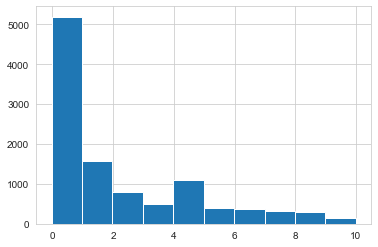

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.set_style('whitegrid')
plt.hist(df['Health_Score'] ,bins=10)
plt.show()

Output

In [ ]:
df.to_csv('Notebooks Data Process/4. Health_Score_User.csv',index=0)